In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import threading
import math
import pandas as pd
from scipy.optimize import minimize
import asyncio
import datetime
import hashlib
import os
import json

In [2]:
def change(filename):
        f = open(f"{filename}.txt", "r")
        out = open(f"{filename}.csv", "w")
        for line in f:
                change = line.replace("\t", ",")
                out.write(change)

In [3]:
change("Demand")

In [4]:
def read_file(filename):
    with open(filename,"r") as f:
        df = pd.read_csv(f,header=None)
        return df.to_numpy()

In [5]:
shops = read_file("Demand.csv")
values = np.array(shops[:, 3])
points = np.array(shops[:, 1:3])
x_range = [1, 9]
y_range = [0, 9]
n = len(values)
cost = 40
TransCost = np.array([10 ** 5] * n)
tried_labels = {}

In [6]:
def constrained_kmeans(points, values, max_sum, m):
    clusters = KMeans(n_clusters=m).fit(points)
    labels = clusters.labels_
    max_itr = 100
    cur = 0
    check = False
    while cur < max_itr:
        cur += 1
        labels_hash = hashlib.sha256(labels.tobytes()).hexdigest()
        if labels_hash in tried_labels:
            continue
        
        tried_labels[labels_hash] = True
        cluster_sums = [np.sum(values[labels == i]) for i in range(m)]
        if all(sum_val < max_sum for sum_val in cluster_sums):
            check = True
            break
        for i, sum_val in enumerate(cluster_sums):
            if sum_val >= max_sum:
                indices = np.where(labels == i)[0]
                np.random.shuffle(indices)
                for idx in indices:
                    for j in range(m):
                        if j != i and np.sum(values[labels == j]) + values[idx] < max_sum:
                            labels[idx] = j
                            break
    if check == True:
        return labels
    return -1

# Function to find the geometric median
def geometric_median(X, weights, eps=1e-5):
    def objective(y):
        distances = cdist(X, [y])
        weighted_sum = np.sum(distances * weights[:, np.newaxis])
        return weighted_sum
    
    y = np.mean(X, axis=0)
    result = minimize(objective, y, method='SLSQP')
    return result.x

# Function to calculate weighted sum of distances
def calculate_weighted_sum_of_distances(medians, points, values, labels):
    weighted_sums_of_distances = []
    for i, median in enumerate(medians):
        if median is not None:
            cluster_points = points[labels == i]
            cluster_values = values[labels == i]
            distances = np.linalg.norm(cluster_points - median, axis=1)
            weighted_distances = distances * cluster_values
            weighted_sum_of_distances = np.sum(weighted_distances)
            weighted_sums_of_distances.append(weighted_sum_of_distances)
        else:
            weighted_sums_of_distances.append(None)
    return weighted_sums_of_distances
    
# Function to plot clusters
def plot_clusters(points, labels, medians, filename='clusters_with_medians.png'):
    plt.figure(figsize=(15, 15))
    colors = plt.get_cmap('tab10', len(medians))
    for i in range(len(medians)):
        cluster_points = points[labels == i]
        if len(cluster_points) > 0:
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f'Cluster {i}')
            if medians[i] is not None:
                plt.scatter(medians[i][0], medians[i][1], color='black', marker='x', s=100, label=f'Median {i}')
                for point in cluster_points:
                    plt.plot([medians[i][0], point[0]], [medians[i][1], point[1]], color=colors(i), linestyle='-')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Clusters and Geometric Medians with Connecting Lines')
    plt.legend()
    plt.grid(True)
    global_lock = threading.Lock()
    while global_lock.locked():
        continue
    global_lock.acquire()
    #plt.savefig(filename, dpi=300)
    global_lock.release()
    plt.close()

# Main function to run the tasks
def run_task(idx, points, values, startm, endm, max_sum, try_num):
    plt.ioff()
    print(f"Thread {idx} Started")
    file_name = f"Task{idx}.txt"
    file_name1 = f"Task_ans{idx}.txt"
    f = open(file_name, "w")
    f1 = open(file_name1, "w")
    for m in range(startm, endm):
        if m >= len(values):
            break
        k = [10000000000] * 5
        ans = 0
        for runtime in range(try_num):  
            labels = constrained_kmeans(points, values, max_sum, m)
            if type(labels) is int:
                check = False
                break
            geometric_medians = []
            for i in range(m):
                cluster_points = points[labels == i]
                cluster_values = values[labels == i]
                if len(cluster_points) > 0:
                    geometric_median_point = geometric_median(cluster_points, cluster_values)
                    geometric_medians.append(geometric_median_point)
        
            weighted_sums_of_distances = calculate_weighted_sum_of_distances(geometric_medians, points, values, labels)

            for i, sum_dist in enumerate(weighted_sums_of_distances):
                if sum_dist is not None:
                    ans += sum_dist
            
            ans += cost * m
            if k[0] > ans:
                k[0] = ans
                k[1] = m
                k[2] = labels
                k[3] = geometric_medians
                k[4] = weighted_sums_of_distances
        TransCost[m] = k[0]
        f1.write(f"{k[0]} \n")
        if runtime == 10:
            print(f"Finish {runtime} of clusters {m} in thread {idx}")
        # f.write("Geometric medians of clusters: \n")
        f.write(f"{k[1]} \n")
        for i, median in enumerate(k[3]):
            f.write(f"{median} \n")
        # f.write("Sum of distances from geometric median to other points in each cluster: \n")
        # for i, sum_dist in enumerate(k[4]):
        #     f.write(f"Cluster {i}: {sum_dist} \n")
        # plot_filename = f'Nigga{k[1]}.png'
        #plot_clusters(points, k[2], k[3], filename=plot_filename)
    print(f"Thread {idx} Finishes")

if __name__ == "__main__":
    max_sum = 1000
    threads = []
    try_num = 3
    for i in range(1, 10):
        startm = i * 20 + 1
        endm = (i + 1) * 20 + 1
        t = threading.Thread(target=run_task, args=(i, points, values, startm, endm, max_sum, try_num))
        threads.append(t)
        t.start()
    
    for t in threads:
        t.join()
    print("All threads have finished.")
    run_task(0, points, values, 6, 21, max_sum, try_num)
    print("Completed all tasks.")



Thread 1 Started
Thread 2 Started
Thread 3 Started
Thread 4 Started
Thread 5 Started
Thread 6 Started
Thread 7 Started
Thread 8 Started
Thread 9 Started
Thread 1 Finishes
Thread 2 Finishes
Thread 3 Finishes
Thread 4 Finishes
Thread 5 Finishes
Thread 6 Finishes
Thread 7 Finishes
Thread 9 Finishes
Thread 8 Finishes
All threads have finished.
Thread 0 Started
Thread 0 Finishes
Completed all tasks.


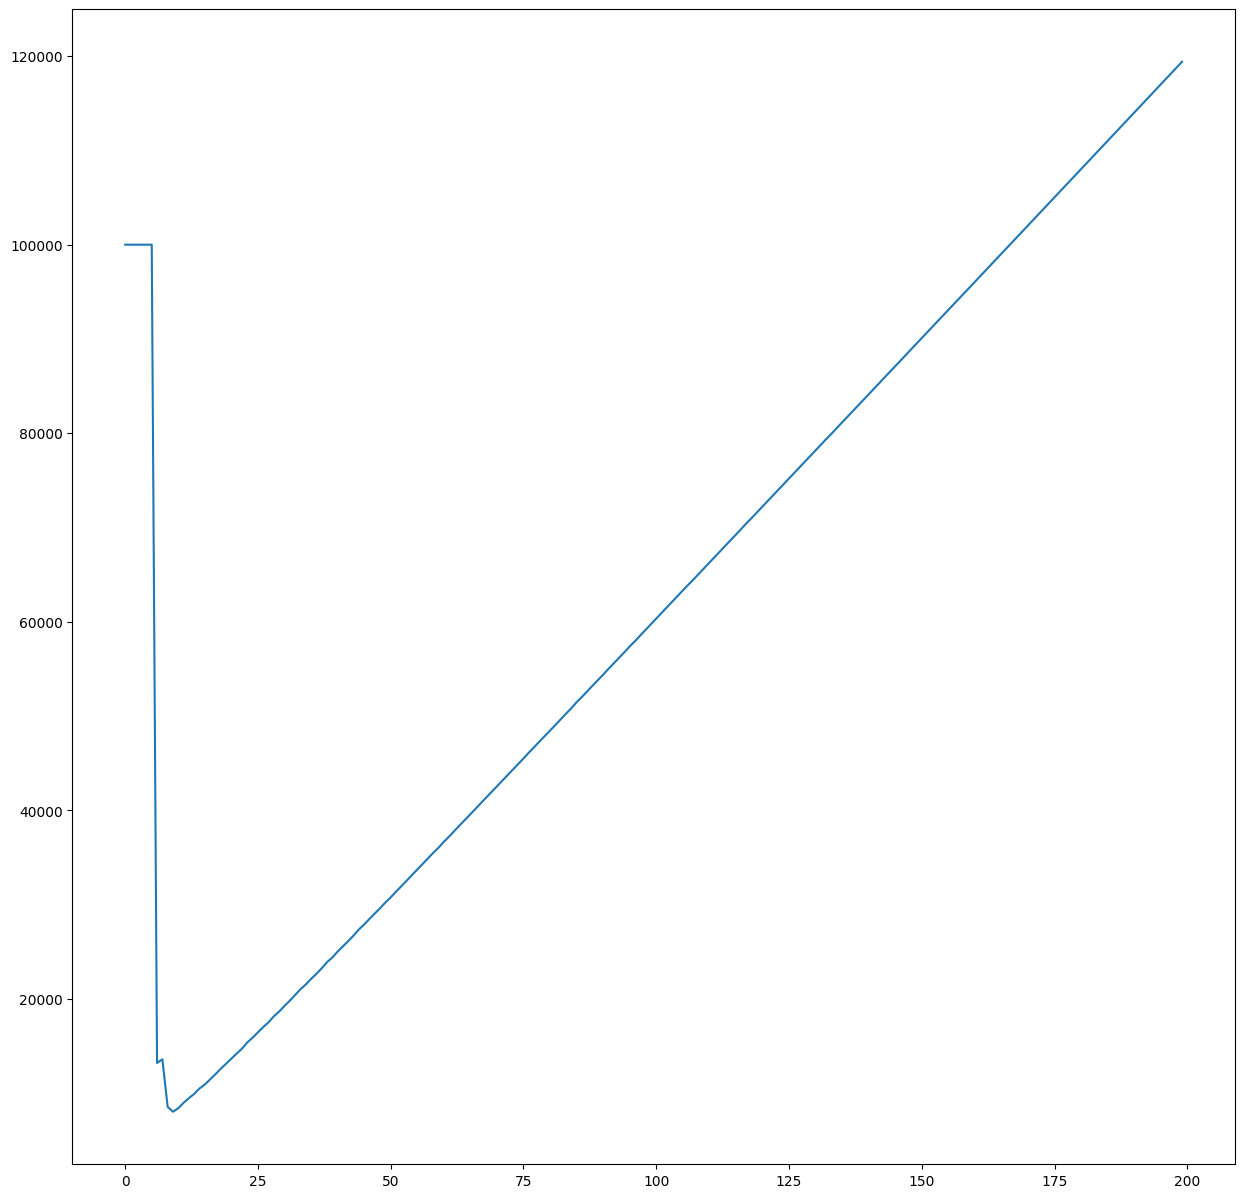

9


In [7]:
minn = [1e9,-1]
for i in range(6, len(TransCost)):
    if (TransCost[i] < minn[0]):
        minn = [TransCost[i], i]

plt.figure(figsize=(15,15))
plt.plot(TransCost)
plt.savefig('TotalCost.png')
plt.show()

print(minn[1])

In [9]:
print(TransCost)
print(minn[0])

[100000 100000 100000 100000 100000 100000  13210  13595   8561   8032
   8411   8987   9479   9928  10506  10922  11468  12020  12599  13139
  13672  14204  14732  15389  15896  16463  17021  17526  18166  18666
  19261  19818  20430  21026  21535  22122  22660  23244  23899  24391
  25021  25578  26136  26721  27366  27904  28489  29065  29628  30232
  30777  31382  31956  32548  33146  33721  34326  34929  35494  36039
  36666  37229  37828  38423  39005  39593  40196  40783  41373  41951
  42556  43133  43724  44339  44916  45505  46123  46694  47306  47883
  48461  49062  49654  50249  50831  51471  52033  52629  53231  53811
  54389  55007  55596  56177  56773  57388  57951  58562  59147  59755
  60342  60942  61537  62127  62719  63315  63916  64486  65084  65689
  66282  66877  67478  68063  68654  69252  69846  70462  71032  71628
  72230  72819  73427  74014  74605  75195  75804  76398  76976  77582
  78183  78772  79376  79950  80561  81148  81743  82347  82933  83532
  8412